In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# Helpful for copy-pasting:
def clean_output(input_list):
    cleaned = ', '.join(input_list)
    print(cleaned)

 ----------------------------------------------
 **Exploring models**
-
 ----------------------------------------------

In [3]:
# Remove identifiers and non-feature columns. Right now only worrying about VOCs, not demographics yet.
df_main = pd.read_csv("df_main_normalized.csv")

y = df_main["TB Status"]  # Target
columns_to_drop = [
    "PID",
    "TB Status",
    "Age",
    "BMI",
    "HIV Status"
]
X = df_main.drop(columns=columns_to_drop)  # Features without demographics for now

In [4]:
# QC Checks
print(np.isnan(X).sum().sum())
print(np.isinf(X).sum().sum())
# print(X.describe())
print((X.std() == 0).sum())  # Number of zero-variance features

0
0
0


Above sets up the data and removes the target from the features.

The next cell below is to figure out what number of features is appropriate for SVM-RFE.

In [5]:
# I trust my model and the ROC-AUC is stable so I'm going to supress some warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*divide by zero encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*overflow encountered in matmul.*")

****SVM-RFE SECTION****

5 features → ROC-AUC: 0.755
10 features → ROC-AUC: 0.808
15 features → ROC-AUC: 0.815
20 features → ROC-AUC: 0.807
25 features → ROC-AUC: 0.780
30 features → ROC-AUC: 0.781
35 features → ROC-AUC: 0.779
40 features → ROC-AUC: 0.760


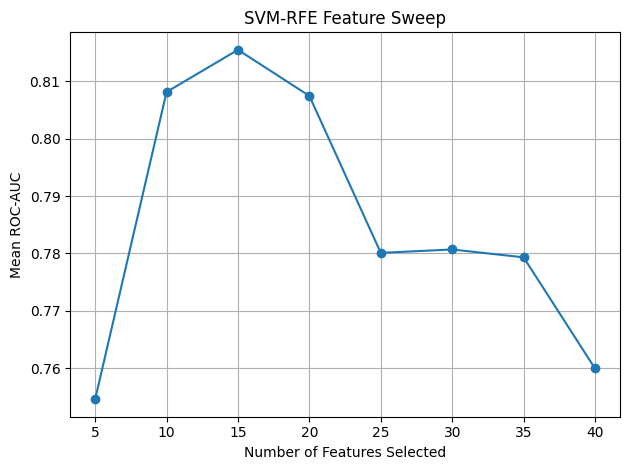

In [6]:
# Configs
svc = LinearSVC(C=1, max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = list(range(5, min(41, X.shape[1]), 5))
scores = []

# Sweep
for n in feature_counts:
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print(f"{n} features → ROC-AUC: {score:.3f}")

plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean ROC-AUC")
plt.title("SVM-RFE Feature Sweep")
plt.grid(True)
plt.tight_layout()
plt.savefig("output2_SVM-RFE Feature Sweep.pdf", bbox_inches="tight")
plt.show()

**Note to Self** I'm getting a ton of runtime warnings related to divide by zero encoutered. I'm guessing this is due to zero variance in some columns maybe? Everything normalized well so I dont think it's a skew issue. Going to try to run a variance filter.

Tried the variance filter. it didn't drop anything so these errors are something else...



Based off of the ROC-AUC, we are selecting 10 features. 15 does show better mean ROC, but looking for a simpler model

In [7]:
feature_number_decision = 10


SVM-RFE: ROC-AUC vs. C Sweep (10 features)
C=0.001  → Mean ROC-AUC: 0.8625
C=0.01   → Mean ROC-AUC: 0.8638
C=0.1    → Mean ROC-AUC: 0.8154
C=1      → Mean ROC-AUC: 0.8081
C=10     → Mean ROC-AUC: 0.7996


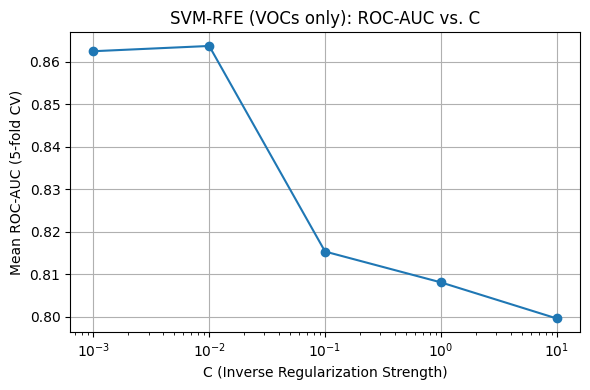

In [8]:
voc_columns = [col for col in df_main.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
X_voc = df_main[voc_columns]
y_voc = df_main["TB Status"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sweep C values (strong to weak regularization)
C_values = [0.001, 0.01, 0.1, 1, 10]
svm_auc_scores = []

# Choose fixed number of features for fair comparison (e.g., 5 based on earlier RFE)
n_features = feature_number_decision

print(f"\nSVM-RFE: ROC-AUC vs. C Sweep ({feature_number_decision} features)")

for C in C_values:
    svc = LinearSVC(C=C, max_iter=10000)
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n_features)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X_voc, y_voc, cv=cv, scoring='roc_auc').mean()
    svm_auc_scores.append(score)
    print(f"C={C:<6} → Mean ROC-AUC: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(C_values, svm_auc_scores, marker='o')
plt.xscale("log")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("SVM-RFE (VOCs only): ROC-AUC vs. C")
plt.grid(True)
plt.tight_layout()
plt.savefig("output3_SVM-RFE C Sweep.pdf", bbox_inches="tight")
plt.show()

In [9]:
# Based on the above graph
C_for_SVM = 0.01

In [10]:
svm = svc = LinearSVC(C=C_for_SVM, max_iter=10000)

# select top 5
rfe = RFE(estimator=svm, n_features_to_select=feature_number_decision, step=1)

# Fit RFE model
rfe.fit(X, y)

RFE(estimator=LinearSVC(C=0.01, max_iter=10000), n_features_to_select=10)

In [11]:
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

# Rankings (1 = selected)
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Top 20 ranked features:")
print(ranking.head(20))

Selected features: ['000098-86-2_group2', '000110-88-3_group1', '000110-98-5_group1', '000149-57-5_group1', '001074-43-7_group1', '001122-82-3_group1', '001762-27-2_group1', '019549-87-2_group1', '054446-78-5_group1', '1000132-10-9_group2']
Top 20 ranked features:
001762-27-2_group1      1
000149-57-5_group1      1
1000132-10-9_group2     1
000110-98-5_group1      1
054446-78-5_group1      1
001122-82-3_group1      1
001074-43-7_group1      1
000098-86-2_group2      1
019549-87-2_group1      1
000110-88-3_group1      1
002216-33-3_group1      2
000074-95-3_group1      3
000109-52-4_group1      4
063521-76-6_group3      5
000124-19-6_group1      6
000100-80-1_group1      7
038165-93-4_group1      8
000107-83-5_group2      9
000123-35-3_group1     10
000353-66-2_group1     11
dtype: int64


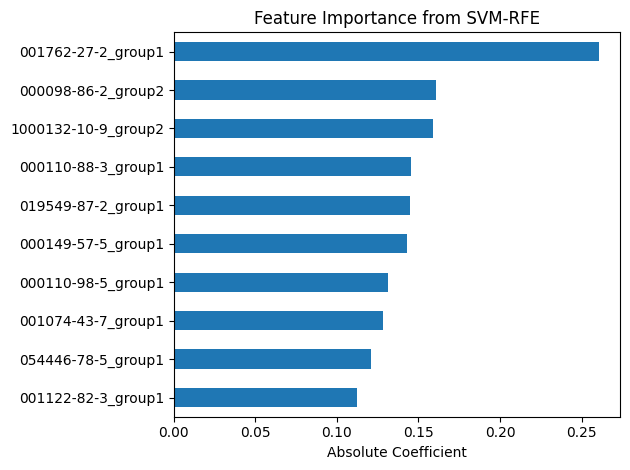

In [12]:
# Visualizing
# Refit SVM just on selected features for coefficient extraction
svm_testing_features = selected_features
svm.fit(X[svm_testing_features], y)
coefs = pd.Series(np.abs(svm.coef_[0]), index=selected_features)

# Plot
coefs.sort_values().plot(kind='barh')
plt.title("Feature Importance from SVM-RFE")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

In [13]:
# Cross-validate
# Needing this LinearSVC and not just linear. The data is fine but it's breaking. Probably too many features for low number of samples?
# LinearSVC has a better solver for higher dimensions.
pipeline = Pipeline([
    ("feature_selection", RFE(LinearSVC(C=C_for_SVM, max_iter=10000), n_features_to_select=feature_number_decision)),
    ("svm", LinearSVC(C=1, max_iter=10000))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds seems standard by literature. Random state of 42 similar to above.
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8587 ± 0.0402


****LASSO****

In [14]:
# LASSO with l1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.10, max_iter=10000)  # A lower C means fewer features (0.5, 0.1)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('lasso', lasso)
])

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8538 ± 0.0284


**NOTE** These errors are the same reason as with SVM-RFE, that the dim of the data is very high while the n_sample count isn't super large as well.


LASSO-selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
000110-98-5_group1        0.224246    1.251379
002216-33-3_group1        0.040821    1.041666
000353-66-2_group1       -0.015748    0.984376
063521-76-6_group3       -0.021954    0.978285
038165-93-4_group1       -0.035628    0.964999
000074-95-3_group1       -0.035650    0.964978
001122-82-3_group1       -0.041069    0.959763
000124-19-6_group1       -0.071053    0.931413
001074-43-7_group1       -0.107758    0.897845
000103-65-1_group1       -0.108533    0.897150
054446-78-5_group1       -0.144885    0.865121
000109-52-4_group1       -0.182875    0.832873
000098-86-2_group2       -0.183092    0.832692
000110-88-3_group1       -0.186261    0.830057
019549-87-2_group1       -0.191537    0.825689
1000132-10-9_group2      -0.236402    0.789463
001762-27-2_group1       -0.736847    0.478621


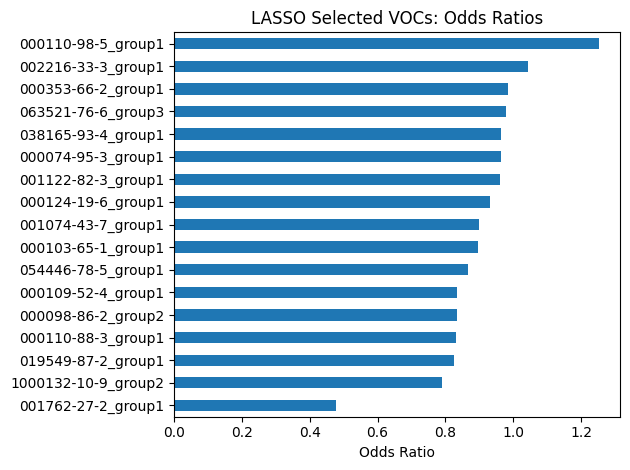

In [15]:
# Fit on full dataset
lasso.fit(X, y)

# coef and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# Combine into a df for report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-selected features with odds ratios:")
print(summary_df)

# visualize odds ratios
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO Selected VOCs: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

Was there overlap with LASSO's selection and SVM-RFE?
YES!

This similiarity makes sense, as these are, ideally, impactful predictors.

****LASSO Based On SVM-RFE Features****

Mean ROC-AUC (LASSO on SVM-RFE): 0.8675 ± 0.0298

LASSO-on-RFE selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
000110-98-5_group1        0.268218    1.307632
001122-82-3_group1       -0.023311    0.976958
001074-43-7_group1       -0.153466    0.857730
054446-78-5_group1       -0.166350    0.846750
000110-88-3_group1       -0.207572    0.812555
019549-87-2_group1       -0.234713    0.790798
1000132-10-9_group2      -0.279194    0.756393
000098-86-2_group2       -0.296262    0.743592
001762-27-2_group1       -0.797734    0.450348


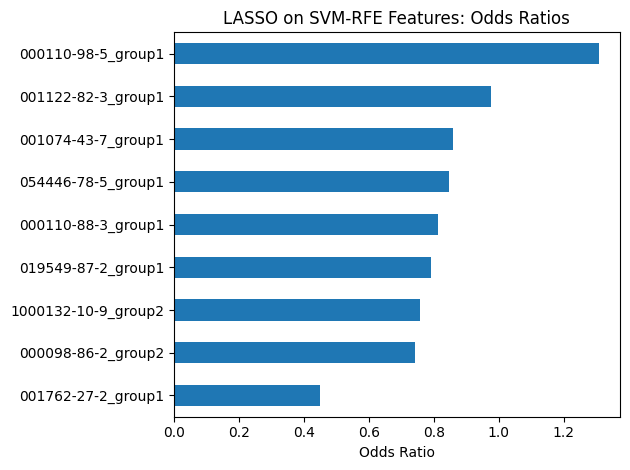

In [16]:
# SVM-RFE selected features:

selected_features = svm_testing_features

X_sub = df_main[selected_features]
y = df_main["TB Status"]  # this hasn't changed

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)  # same penalty as previous LASSO

# CV performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X_sub, y, cv=cv, scoring="roc_auc")
print(f"Mean ROC-AUC (LASSO on SVM-RFE): {scores.mean():.4f} ± {scores.std():.4f}")

# Fit final model
lasso.fit(X_sub, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X_sub.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-on-RFE selected features with odds ratios:")
print(summary_df)

# Visualize
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO on SVM-RFE Features: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

----------------------------------------------

**Testing models post exploration**
-

 ----------------------------------------------

In [17]:
x_all_no_demo = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])
y_all_no_demo = df_main["TB Status"]

# 80/20 spilt
x_train_no_demo, x_test_no_demo, y_train_no_demo, y_test_no_demo = train_test_split(
    x_all_no_demo, y_all_no_demo, test_size=0.2, stratify=y_all_no_demo, random_state=42
)

print(f"Train size: {x_train_no_demo.shape[0]}, Test size: {x_test_no_demo.shape[0]}")

Train size: 185, Test size: 47


In [18]:
# Fit RFE to training data
svm = LinearSVC(C=C_for_SVM, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=feature_number_decision)
rfe.fit(x_train_no_demo, y_train_no_demo)

# Get VOCs
svm_rfe_features = x_train_no_demo.columns[rfe.support_].tolist()
svm_rfe_features_no_demos = svm_rfe_features  # this one line is for later comparison
print("SVM-RFE selected features:", svm_rfe_features)
print('\n')
clean_output(svm_rfe_features)

# Training model on selected VOCs
svm_final_no_demo = LinearSVC(C=C_for_SVM, max_iter=10000)
svm_final_no_demo.fit(x_train_no_demo[svm_rfe_features], y_train_no_demo)

SVM-RFE selected features: ['000098-86-2_group2', '000104-76-7_group1', '000109-52-4_group1', '000110-88-3_group1', '000110-98-5_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2', '1000309-13-0_group1']


000098-86-2_group2, 000104-76-7_group1, 000109-52-4_group1, 000110-88-3_group1, 000110-98-5_group1, 001074-43-7_group1, 001762-27-2_group1, 019549-87-2_group1, 1000132-10-9_group2, 1000309-13-0_group1


LinearSVC(C=0.01, max_iter=10000)

Note: Selected features differ from exploratory run

In [19]:
# LASSO
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_no_demo, y_train_no_demo)

# Get non-zero VOCs
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_no_demo.columns)
lasso_full_features = coefs_full[coefs_full != 0].index.tolist()
lasso_full_features_no_demos = lasso_full_features  # this one line is for later comparisons
print("LASSO (Full) selected features:", lasso_full_features)
print('\n')
clean_output(lasso_full_features)


# Refit model using only those features
lasso_final_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_no_demo.fit(x_train_no_demo[lasso_full_features], y_train_no_demo)

LASSO (Full) selected features: ['000103-65-1_group1', '000109-52-4_group1', '000110-88-3_group1', '000110-98-5_group1', '000124-19-6_group1', '000353-66-2_group1', '000615-74-7_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2', '1000308-17-8_group1', '1000309-13-0_group1']


000103-65-1_group1, 000109-52-4_group1, 000110-88-3_group1, 000110-98-5_group1, 000124-19-6_group1, 000353-66-2_group1, 000615-74-7_group1, 001074-43-7_group1, 001762-27-2_group1, 019549-87-2_group1, 1000132-10-9_group2, 1000308-17-8_group1, 1000309-13-0_group1


LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [20]:
# LASSO on SVM-RFE
# ID VOC feature overlap
overlap_features = list(set(svm_rfe_features_no_demos) & set(lasso_full_features_no_demos))
print("Overlap features used in LASSO-on-RFE:", overlap_features)
print('\n')
clean_output(overlap_features)

Overlap features used in LASSO-on-RFE: ['1000309-13-0_group1', '001074-43-7_group1', '000110-88-3_group1', '019549-87-2_group1', '001762-27-2_group1', '1000132-10-9_group2', '000109-52-4_group1', '000110-98-5_group1']


1000309-13-0_group1, 001074-43-7_group1, 000110-88-3_group1, 019549-87-2_group1, 001762-27-2_group1, 1000132-10-9_group2, 000109-52-4_group1, 000110-98-5_group1


In [21]:
# Train LASSO
lasso_on_rfe_no_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_no_demo.fit(x_train_no_demo[overlap_features], y_train_no_demo)

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

**Running models on Test Sets**

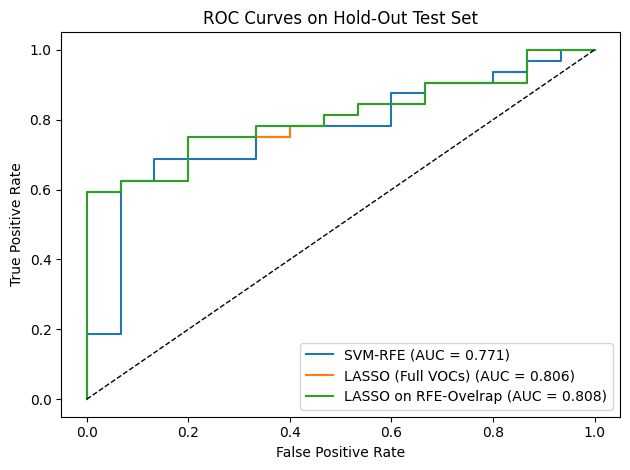


Final ROC-AUCs on Test Set:
SVM-RFE (Top 10): 0.771
LASSO (Full VOCs): 0.806
LASSO on Overlap: 0.808


In [22]:
def plot_model_roc(model, x_test, y_test, label):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
    return roc_auc


# Plot all
plt.figure()


auc_svm = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE")
auc_lasso_full = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features], y_test_no_demo, "LASSO (Full VOCs)")
auc_lasso_overlap = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO on RFE-Ovelrap")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top {feature_number_decision}): {auc_svm:.3f}")
print(f"LASSO (Full VOCs): {auc_lasso_full:.3f}")
print(f"LASSO on Overlap: {auc_lasso_overlap:.3f}")

In [23]:
coefs = pd.Series(lasso_on_rfe_no_demo.coef_[0], index=overlap_features)
odds_ratios = np.exp(coefs)
print(pd.DataFrame({'Log-Odds': coefs, 'Odds Ratio': odds_ratios}))

                     Log-Odds  Odds Ratio
1000309-13-0_group1 -0.101604    0.903387
001074-43-7_group1  -0.175428    0.839098
000110-88-3_group1  -0.256510    0.773747
019549-87-2_group1  -0.260026    0.771032
001762-27-2_group1  -0.692627    0.500260
1000132-10-9_group2 -0.351258    0.703802
000109-52-4_group1  -0.359314    0.698155
000110-98-5_group1   0.149410    1.161149


 ----------------------------------------------

**Adding in Demographics**
-

 ----------------------------------------------

In [24]:
# Reload full dataset with Demos now
df_main = pd.read_csv("df_main_normalized.csv")

# Check for missing demos. should be -1 if unknown
print(df_main[["Age", "BMI", "HIV Status"]].isnull().sum())
print(f"Count of -1 in 'Age': {(df_main['Age'] == -1).sum()}")
print(f"Count of -1 in 'BMI': {(df_main['BMI'] == -1).sum()}")
print(f"Count of -1 in 'HIV Status': {(df_main['HIV Status'] == -1).sum()}")

Age           0
BMI           0
HIV Status    0
dtype: int64
Count of -1 in 'Age': 0
Count of -1 in 'BMI': 2
Count of -1 in 'HIV Status': 9


This shows that we are missing:
* 2 BMI values
* 9 HIV statuses

In [25]:
# Drop rows where Age, BMI, or HIV Status is -1 (placeholder for missing)
df_main_clean = df_main[
    (df_main["Age"] != -1) &
    (df_main["BMI"] != -1) &
    (df_main["HIV Status"] != -1)
].copy()

print(f"Rows dropped: {df_main.shape[0] - df_main_clean.shape[0]}")

Rows dropped: 9


In [26]:
# Define features and outcome
x_all_demo = df_main_clean.drop(columns=["PID", "TB Status"])
y_all_demo = df_main_clean["TB Status"]

# Train-test split
x_train_demo, x_test_demo, y_train_demo, y_test_demo = train_test_split(
    x_all_demo, y_all_demo, test_size=0.2, stratify=y_all_demo, random_state=42
)

In [27]:
# SVM-RFE on all VOCs + demographics
svm = LinearSVC(C=C_for_SVM, max_iter=10000)
rfe = RFE(estimator=svm, n_features_to_select=feature_number_decision)
rfe.fit(x_train_demo, y_train_demo)

svm_rfe_features_with_demo = x_train_demo.columns[rfe.support_].tolist()
print("SVM-RFE with demographics selected features:", svm_rfe_features_with_demo)
print('\n')
clean_output(svm_rfe_features_with_demo)

# Final model
svm_final_demo = LinearSVC(C=C_for_SVM, max_iter=10000)
svm_final_demo.fit(x_train_demo[svm_rfe_features_with_demo], y_train_demo)

SVM-RFE with demographics selected features: ['000098-86-2_group2', '000110-88-3_group1', '000110-98-5_group1', '000149-57-5_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '038165-93-4_group1', '054446-78-5_group1', '1000132-10-9_group2']


000098-86-2_group2, 000110-88-3_group1, 000110-98-5_group1, 000149-57-5_group1, 001074-43-7_group1, 001762-27-2_group1, 019549-87-2_group1, 038165-93-4_group1, 054446-78-5_group1, 1000132-10-9_group2


LinearSVC(C=0.01, max_iter=10000)

In [28]:
# fit LASSO on full plus demos
lasso_full = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_full.fit(x_train_demo, y_train_demo)

# selected features
coefs_full = pd.Series(lasso_full.coef_[0], index=x_train_demo.columns)
nonzero_full = coefs_full[coefs_full != 0]
lasso_features_demo = nonzero_full.index.tolist()  # Ensures consistent column order
lasso_full_features_with_demos = nonzero_full.index.tolist()  # this line is for a later comparison
odds_ratios_full = np.exp(nonzero_full)


summary_lasso_full = pd.DataFrame({
    "Log-Odds": nonzero_full,
    "Odds Ratio": odds_ratios_full
}).sort_values("Odds Ratio", ascending=False)

print("LASSO (Full + Demographics) selected features with odds ratios:")
print(summary_lasso_full)
print('\n')
clean_output(lasso_full_features_with_demos)

# refit and evaluate with the test set
lasso_final_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_final_demo.fit(x_train_demo[lasso_features_demo], y_train_demo)

probs_lasso_full_demo = lasso_final_demo.predict_proba(x_test_demo[lasso_features_demo])[:, 1]
auc_lasso_full_demo = roc_auc_score(y_test_demo, probs_lasso_full_demo)
print(f"LASSO (Full + Demos) ROC-AUC on test set: {auc_lasso_full_demo:.4f}")

LASSO (Full + Demographics) selected features with odds ratios:
                     Log-Odds  Odds Ratio
000110-98-5_group1   0.154502    1.167076
BMI                  0.032430    1.032962
000620-14-4_group1  -0.013018    0.987066
1000308-17-8_group1 -0.017058    0.983086
054446-78-5_group1  -0.023582    0.976694
1000401-12-0_group1 -0.025584    0.974740
000353-66-2_group1  -0.049998    0.951232
000103-65-1_group1  -0.053935    0.947493
000098-86-2_group2  -0.072971    0.929628
000110-88-3_group1  -0.186375    0.829963
001074-43-7_group1  -0.194343    0.823376
000109-52-4_group1  -0.212392    0.808648
019549-87-2_group1  -0.217645    0.804411
1000132-10-9_group2 -0.341136    0.710962
001762-27-2_group1  -0.682670    0.505266


BMI, 000098-86-2_group2, 000103-65-1_group1, 000109-52-4_group1, 000110-88-3_group1, 000110-98-5_group1, 000353-66-2_group1, 000620-14-4_group1, 001074-43-7_group1, 001762-27-2_group1, 019549-87-2_group1, 054446-78-5_group1, 1000132-10-9_group2, 1000308-17-8_gro

In [29]:
# LASSO on SVM-RFE ID'd features

# SVM-RFE VOCs
svm_rfe_vocs_demo = svm_rfe_features_with_demo.copy()  # the X number of VOCs from earlier RFE

# add demos
demo_vars = ["Age", "BMI", "HIV Status"]
for var in demo_vars:
    if var not in svm_rfe_vocs_demo:
        svm_rfe_vocs_demo.append(var)

print("Features used in LASSO-on-RFE + Demographics:", svm_rfe_vocs_demo)

# LASSO on training data
lasso_on_rfe_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_demo.fit(x_train_demo[svm_rfe_vocs_demo], y_train_demo)

# Features and ORs
coefs_rfe_demo = pd.Series(lasso_on_rfe_demo.coef_[0], index=svm_rfe_vocs_demo)
nonzero_rfe_demo = coefs_rfe_demo[coefs_rfe_demo != 0]
odds_ratios_rfe_demo = np.exp(nonzero_rfe_demo)

summary_rfe_demo = pd.DataFrame({
    "Log-Odds": nonzero_rfe_demo,
    "Odds Ratio": odds_ratios_rfe_demo
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO (SVM-RFE + Demos) selected features with odds ratios:")
print(summary_rfe_demo)

# Test set
probs_rfe_demo = lasso_on_rfe_demo.predict_proba(x_test_demo[svm_rfe_vocs_demo])[:, 1]
auc_rfe_demo = roc_auc_score(y_test_demo, probs_rfe_demo)
print(f"LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: {auc_rfe_demo:.4f}")

Features used in LASSO-on-RFE + Demographics: ['000098-86-2_group2', '000110-88-3_group1', '000110-98-5_group1', '000149-57-5_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '038165-93-4_group1', '054446-78-5_group1', '1000132-10-9_group2', 'Age', 'BMI', 'HIV Status']

LASSO (SVM-RFE + Demos) selected features with odds ratios:
                     Log-Odds  Odds Ratio
000110-98-5_group1   0.184795    1.202971
BMI                  0.031667    1.032173
038165-93-4_group1  -0.022394    0.977855
054446-78-5_group1  -0.065274    0.936810
000098-86-2_group2  -0.181507    0.834012
000110-88-3_group1  -0.229014    0.795318
001074-43-7_group1  -0.240327    0.786370
019549-87-2_group1  -0.242350    0.784781
1000132-10-9_group2 -0.364761    0.694363
001762-27-2_group1  -0.698233    0.497463
LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: 0.8511


Adding in demographics made the model have a lower ROC-AUC.

Going forward, going to include the new VOCs, but remove the demographics.

**TODO**: check this with smoking/sex still

In [30]:
# LASSO on SVM-RFE ID'd features WITHOUT added DEMOS

# SVM-RFE VOCs
svm_rfe_vocs_demo = svm_rfe_features_with_demo.copy()  # the X number of VOCs from earlier RFE

print("Features used in LASSO-on-RFE + Demographics:", svm_rfe_vocs_demo)
print('\n')
clean_output(svm_rfe_vocs_demo)

# LASSO on training data
lasso_on_rfe_demo = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)
lasso_on_rfe_demo.fit(x_train_demo[svm_rfe_vocs_demo], y_train_demo)

# Features and ORs
coefs_rfe_demo = pd.Series(lasso_on_rfe_demo.coef_[0], index=svm_rfe_vocs_demo)
nonzero_rfe_demo = coefs_rfe_demo[coefs_rfe_demo != 0]
odds_ratios_rfe_demo = np.exp(nonzero_rfe_demo)

summary_rfe_demo = pd.DataFrame({
    "Log-Odds": nonzero_rfe_demo,
    "Odds Ratio": odds_ratios_rfe_demo
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO (SVM-RFE + Demos) selected features with odds ratios:")
print(summary_rfe_demo)

# Test set
probs_rfe_demo = lasso_on_rfe_demo.predict_proba(x_test_demo[svm_rfe_vocs_demo])[:, 1]
auc_rfe_demo = roc_auc_score(y_test_demo, probs_rfe_demo)
print(f"LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set: {auc_rfe_demo:.4f}")

Features used in LASSO-on-RFE + Demographics: ['000098-86-2_group2', '000110-88-3_group1', '000110-98-5_group1', '000149-57-5_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '038165-93-4_group1', '054446-78-5_group1', '1000132-10-9_group2']


000098-86-2_group2, 000110-88-3_group1, 000110-98-5_group1, 000149-57-5_group1, 001074-43-7_group1, 001762-27-2_group1, 019549-87-2_group1, 038165-93-4_group1, 054446-78-5_group1, 1000132-10-9_group2

LASSO (SVM-RFE + Demos) selected features with odds ratios:
                     Log-Odds  Odds Ratio
000110-98-5_group1   0.153566    1.165985
038165-93-4_group1  -0.024255    0.976037
054446-78-5_group1  -0.063403    0.938566
000098-86-2_group2  -0.160766    0.851491
000110-88-3_group1  -0.192647    0.824773
001074-43-7_group1  -0.224832    0.798650
019549-87-2_group1  -0.231559    0.793296
1000132-10-9_group2 -0.327777    0.720524
001762-27-2_group1  -0.684525    0.504330
LASSO on SVM-RFE VOCs + Demos ROC-AUC on test set

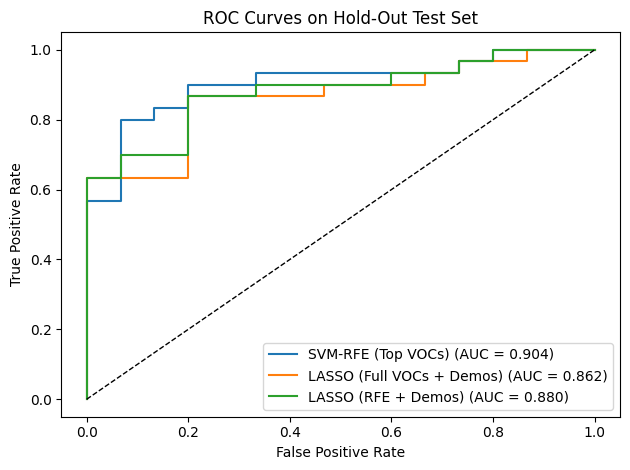


Final ROC-AUCs on Test Set:
SVM-RFE (Top 10 VOCs): 0.904
LASSO (Full VOCs + Demos): 0.862
LASSO (RFE + Demos): 0.880


In [31]:
# same fxn as earlier but putting in this block for quicker testing
def plot_model_roc(model, x_test, y_test, label, linestyle='-', color=None):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})', linestyle=linestyle, color=color)
    return roc_auc


plt.figure()

auc_svm = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (Top VOCs)")
auc_lasso_full = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)")
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE + Demos)")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Hold-Out Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


print("\nFinal ROC-AUCs on Test Set:")
print(f"SVM-RFE (Top {feature_number_decision} VOCs): {auc_svm:.3f}")
print(f"LASSO (Full VOCs + Demos): {auc_lasso_full:.3f}")
print(f"LASSO (RFE + Demos): {auc_lasso_rfe_demo:.3f}")

 ----------------------------------------------

**Looking at influence of demographics**
-

 ----------------------------------------------

At this point, the SVM-RFE on demographics was the most robus. Yet, in order to test if demographics are playing a role, as these models select the most features, I'll be using these

In [32]:
# SVM (more focused on LASSO due to higher ROC-AUC values, but want to see this still)

# Convert to sets
svm_rfe_set_no_demos = set(svm_rfe_features_no_demos)
svm_rfe_set_with_demos = set(svm_rfe_features_with_demo)

# Compare
overlap = svm_rfe_set_no_demos & svm_rfe_set_with_demos
dropped = svm_rfe_set_no_demos - svm_rfe_set_with_demos
added = svm_rfe_set_with_demos - svm_rfe_set_no_demos

# Output
print(f"Shared features in both SVM models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features SVM (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features SVM (only selected when demos were included) ({len(added)}):")
print(sorted(added))

# LASSO:

# Convert to sets
lasso_set_no_demos = set(lasso_full_features_no_demos)
lasso_set_with_demos = set(lasso_full_features_with_demos)

# Compare
overlap = lasso_set_no_demos & lasso_set_with_demos
dropped = lasso_set_no_demos - lasso_set_with_demos
added = lasso_set_with_demos - lasso_set_no_demos

# Output
print(f"Shared features in both LASSO models ({len(overlap)}):")
print(sorted(overlap))

print(f"\nDropped features LASSO (in no-demo model, but not in demo model) ({len(dropped)}):")
print(sorted(dropped))

print(f"\nAdded features LASSO (only selected when demos were included) ({len(added)}):")
print(sorted(added))

Shared features in both SVM models (7):
['000098-86-2_group2', '000110-88-3_group1', '000110-98-5_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2']

Dropped features SVM (in no-demo model, but not in demo model) (3):
['000104-76-7_group1', '000109-52-4_group1', '1000309-13-0_group1']

Added features SVM (only selected when demos were included) (3):
['000149-57-5_group1', '038165-93-4_group1', '054446-78-5_group1']
Shared features in both LASSO models (10):
['000103-65-1_group1', '000109-52-4_group1', '000110-88-3_group1', '000110-98-5_group1', '000353-66-2_group1', '001074-43-7_group1', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2', '1000308-17-8_group1']

Dropped features LASSO (in no-demo model, but not in demo model) (3):
['000124-19-6_group1', '000615-74-7_group1', '1000309-13-0_group1']

Added features LASSO (only selected when demos were included) (5):
['000098-86-2_group2', '000620-14-4_group1', '054446-78-5_gro

**SVM**

There were changes. Were any of these dropped VOCs correlated with BMI? using pearson

**LASSO**

There were changes. Were any of these dropped VOCs correlated with BMI? using pearson

In [33]:
# VOC-BMI correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]
correlations = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])

# List of VOCs dropped when demographics were included
changed_VOCs = [item for item in dropped.union(added) if item not in ["Age", "BMI"]]
# Check each one's correlation with BMI
print("Dropped VOCs and their correlation with BMI:")
for voc in changed_VOCs:
    if voc in correlations:
        corr = correlations[voc]
        print(f"{voc:25} -> correlation with BMI: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with BMI:
000615-74-7_group1        -> correlation with BMI: 0.070
1000309-13-0_group1       -> correlation with BMI: -0.034
054446-78-5_group1        -> correlation with BMI: 0.048
000124-19-6_group1        -> correlation with BMI: 0.098
1000401-12-0_group1       -> correlation with BMI: 0.121
000620-14-4_group1        -> correlation with BMI: 0.103
000098-86-2_group2        -> correlation with BMI: 0.105


In general: The VOCs dropped from the model after adding demographics are not strongly correlated with BMI, suggesting they were excluded due to interactions with other selected features or shifts in model penalty allocation, instead of directly overlapping with BMI’s signal.

In [34]:
# doing the same above, but with age instead of BMI

# Correlate each VOC with Age
correlations_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])

# Check age correlation for VOCs dropped when demographics were added
print("Dropped VOCs and their correlation with Age:")
for voc in changed_VOCs:
    if voc in correlations_age:
        corr = correlations_age[voc]
        print(f"{voc:25} -> correlation with Age: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with Age:
000615-74-7_group1        -> correlation with Age: 0.132
1000309-13-0_group1       -> correlation with Age: -0.026
054446-78-5_group1        -> correlation with Age: 0.055
000124-19-6_group1        -> correlation with Age: 0.029
1000401-12-0_group1       -> correlation with Age: -0.137
000620-14-4_group1        -> correlation with Age: 0.046
000098-86-2_group2        -> correlation with Age: 0.081


With the five VOCs dropped from the LASSO model when demographic variables were included, none of them demonstrated moderate correlation.

In [35]:
# doing the same above, but with HIV status
# point-biserial correlation for dichotomous data

# VOC with HIV
correlations_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Check correlation for dropped VOCs
print("Dropped VOCs and their correlation with HIV Status:")
for voc in changed_VOCs:
    if voc in correlations_hiv:
        corr = correlations_hiv[voc]
        print(f"{voc:25} -> correlation with HIV Status: {corr:.3f}")
    else:
        print(f"{voc:25} -> not found in data")

Dropped VOCs and their correlation with HIV Status:
000615-74-7_group1        -> correlation with HIV Status: -0.045
1000309-13-0_group1       -> correlation with HIV Status: -0.090
054446-78-5_group1        -> correlation with HIV Status: -0.044
000124-19-6_group1        -> correlation with HIV Status: 0.010
1000401-12-0_group1       -> correlation with HIV Status: -0.106
000620-14-4_group1        -> correlation with HIV Status: -0.038
000098-86-2_group2        -> correlation with HIV Status: -0.001


Again, HIV status doesn't play a ton into this

 ----------------------------------------------

**Summarizing**
-

 ----------------------------------------------

In [36]:
# Recalculate correlations
voc_columns = [col for col in df_main_clean.columns if col not in ["PID", "TB Status", "Age", "BMI", "HIV Status"]]

corr_bmi = df_main_clean[voc_columns].corrwith(df_main_clean["BMI"])
corr_age = df_main_clean[voc_columns].corrwith(df_main_clean["Age"])
corr_hiv = df_main_clean[voc_columns].corrwith(df_main_clean["HIV Status"])

# Collect correlations into a DataFrame
summary_data = []
for voc in changed_VOCs:
    bmi_corr = corr_bmi.get(voc, float("nan"))
    age_corr = corr_age.get(voc, float("nan"))
    hiv_corr = corr_hiv.get(voc, float("nan"))

    if abs(bmi_corr) >= 0.15 or abs(age_corr) >= 0.15 or abs(hiv_corr) >= 0.15:
        likely = "Possibly"
    else:
        likely = "Unlikely"

    summary_data.append({
        "VOC": voc,
        "Corr with BMI": round(bmi_corr, 3),
        "Corr with Age": round(age_corr, 3),
        "Corr with HIV": round(hiv_corr, 3),
        "Likely Influenced": likely
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style\
    .set_caption("Correlation of Dropped VOCs with Demographic Variables")\
    .format({
        "Corr with BMI": "{:.3f}",
        "Corr with Age": "{:.3f}",
        "Corr with HIV": "{:.3f}"
    })\
    .set_properties(**{
        "text-align": "center"
    })\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

styled_summary
styled_summary.to_html("output5_demos_correlation_table.html", escape=True)
summary_df.to_excel("output5_demos_correlation_table.xlsx", index=False)
summary_df

,VOC,Corr with BMI,Corr with Age,Corr with HIV,Likely Influenced
0,000615-74-7_group1,0.070,0.132,-0.045,Unlikely
1,1000309-13-0_group1,-0.034,-0.026,-0.090,Unlikely
2,054446-78-5_group1,0.048,0.055,-0.044,Unlikely
3,000124-19-6_group1,0.098,0.029,0.010,Unlikely
4,1000401-12-0_group1,0.121,-0.137,-0.106,Unlikely
5,000620-14-4_group1,0.103,0.046,-0.038,Unlikely
6,000098-86-2_group2,0.105,0.081,-0.001,Unlikely


In [37]:
roc_data = [
    {"Model": "LASSO (Full)", "Features": "VOCs only", "ROC-AUC": 0.806},
    {"Model": "LASSO (Full)", "Features": "VOCs + Demographics", "ROC-AUC": 0.862},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs only", "ROC-AUC": 0.808},
    {"Model": "LASSO (on RFE VOCs)", "Features": "VOCs + Demographics", "ROC-AUC": 0.880},
    {"Model": "SVM-RFE", "Features": "VOCs only", "ROC-AUC": 0.771},
    {"Model": "SVM-RFE", "Features": "VOCs + Demographics", "ROC-AUC": 0.904}
]
roc_df = pd.DataFrame(roc_data)

roc_df = roc_df.sort_values(by="ROC-AUC", ascending=False)

# Styled table
roc_df.style\
    .set_caption("Model Performance (ROC-AUC Sorted)")\
    .format({"ROC-AUC": "{:.3f}"})\
    .set_properties(**{"text-align": "center"})\
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold")]}
    ])

,Model,Features,ROC-AUC
5,SVM-RFE,VOCs + Demographics,0.904
3,LASSO (on RFE VOCs),VOCs + Demographics,0.880
1,LASSO (Full),VOCs + Demographics,0.862
2,LASSO (on RFE VOCs),VOCs only,0.808
0,LASSO (Full),VOCs only,0.806
4,SVM-RFE,VOCs only,0.771


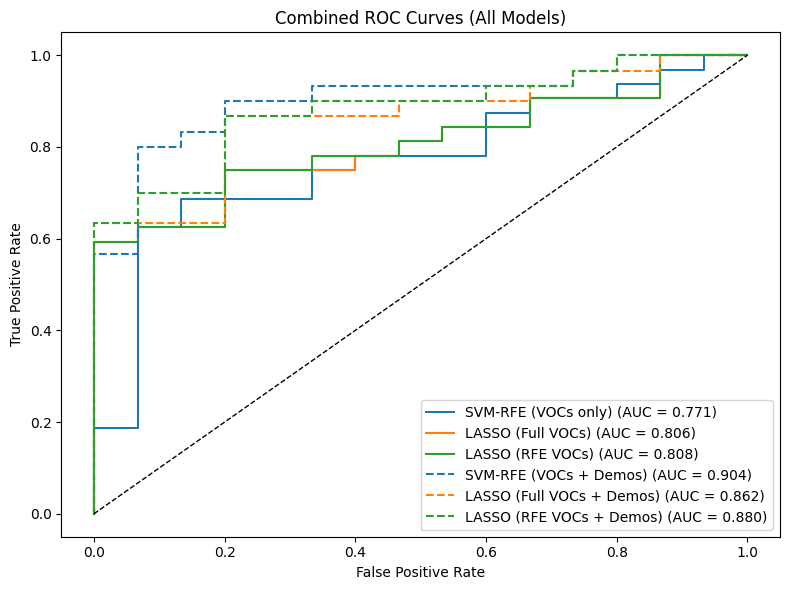


Final ROC-AUCs on Test Set (sorted):
SVM-RFE (VOCs + Demos)              0.904
LASSO (RFE VOCs + Demos)            0.880
LASSO (Full VOCs + Demos)           0.862
LASSO (RFE VOCs)                    0.808
LASSO (Full VOCs)                   0.806
SVM-RFE (VOCs only)                 0.771


In [38]:
plt.figure(figsize=(8, 6))  # calling earlier plot function

# VOC only
auc_svm_voc = plot_model_roc(svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo, "SVM-RFE (VOCs only)", color='tab:blue')
auc_lasso_full_voc = plot_model_roc(lasso_final_no_demo, x_test_no_demo[lasso_full_features_no_demos], y_test_no_demo, "LASSO (Full VOCs)", color='tab:orange')
auc_lasso_rfe_voc = plot_model_roc(lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo, "LASSO (RFE VOCs)", color='tab:green')

# VOC + Demos
auc_svm_demo = plot_model_roc(svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo, "SVM-RFE (VOCs + Demos)", linestyle='--', color='tab:blue')
auc_lasso_full_demo = plot_model_roc(lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo, "LASSO (Full VOCs + Demos)", linestyle='--', color='tab:orange')
auc_lasso_rfe_demo = plot_model_roc(lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo, "LASSO (RFE VOCs + Demos)", linestyle='--', color='tab:green')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves (All Models)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("output4_Combined_ROC_Curves.pdf", bbox_inches="tight")
plt.show()

# Print all AUCs
auc_results = [
    {"Model": "SVM-RFE (VOCs only)", "AUC": auc_svm_voc},
    {"Model": "LASSO (Full VOCs)", "AUC": auc_lasso_full_voc},
    {"Model": "LASSO (RFE VOCs)", "AUC": auc_lasso_rfe_voc},
    {"Model": "SVM-RFE (VOCs + Demos)", "AUC": auc_svm_demo},
    {"Model": "LASSO (Full VOCs + Demos)", "AUC": auc_lasso_full_demo},
    {"Model": "LASSO (RFE VOCs + Demos)", "AUC": auc_lasso_rfe_demo}
]

# Sorting
auc_results_sorted = sorted(auc_results, key=lambda x: x["AUC"], reverse=True)

# Print sort
print("\nFinal ROC-AUCs on Test Set (sorted):")
for entry in auc_results_sorted:
    print(f"{entry['Model']:<35} {entry['AUC']:.3f}")  # the 35 is a padding



**Boostrapping**
---

Bootstrapping what was done for more detail than above

SVM-RFE (VOCs only): AUC = 0.772 (95% CI: 0.622–0.900)
LASSO (Full VOCs): AUC = 0.806 (95% CI: 0.672–0.918)
LASSO (RFE VOCs): AUC = 0.807 (95% CI: 0.677–0.917)
SVM-RFE (VOCs + Demos): AUC = 0.904 (95% CI: 0.802–0.981)
LASSO (Full VOCs + Demos): AUC = 0.862 (95% CI: 0.740–0.958)
LASSO (RFE VOCs + Demos): AUC = 0.881 (95% CI: 0.767–0.966)


,Model,Mean AUC,95% CI Lower,95% CI Upper
3,SVM-RFE (VOCs + Demos),0.904259,0.801560,0.980769
5,LASSO (RFE VOCs + Demos),0.880590,0.767241,0.966346
4,LASSO (Full VOCs + Demos),0.862248,0.739631,0.957778
2,LASSO (RFE VOCs),0.807449,0.677075,0.916667
1,LASSO (Full VOCs),0.806424,0.672215,0.917749
0,SVM-RFE (VOCs only),0.772013,0.622158,0.900000


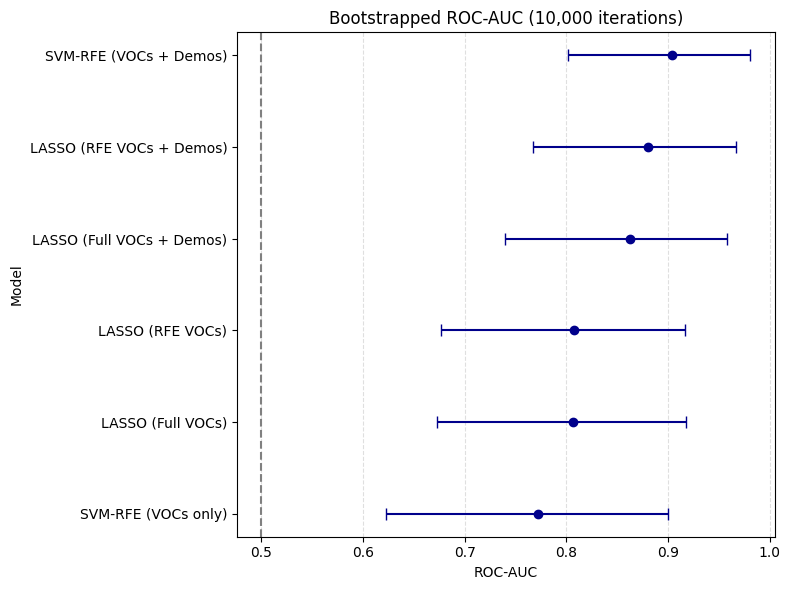

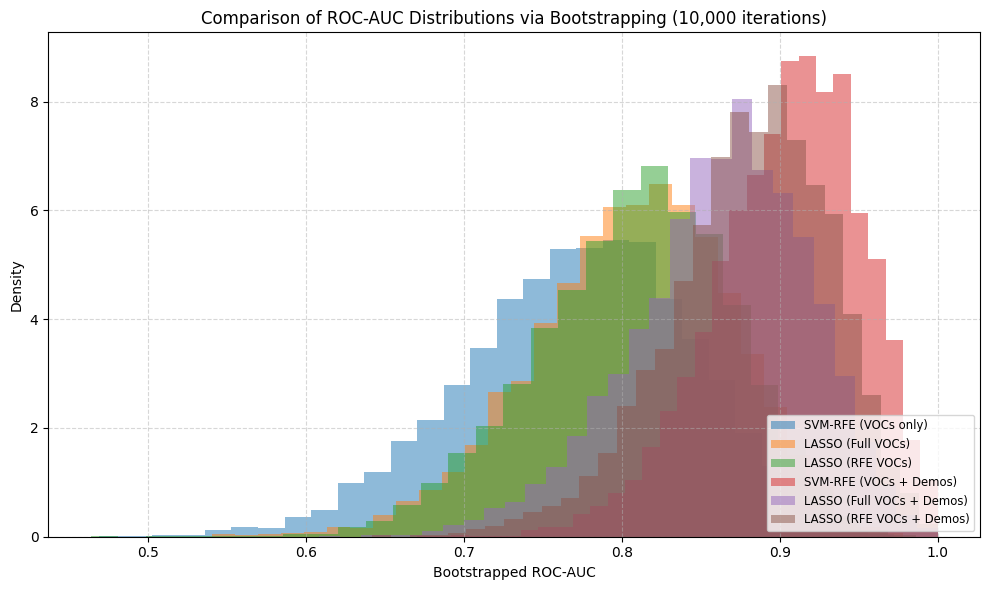

In [39]:
models_info = [
    ("SVM-RFE (VOCs only)", svm_final_no_demo, x_test_no_demo[svm_rfe_features], y_test_no_demo),
    ("LASSO (Full VOCs)", lasso_final_no_demo, x_test_no_demo[lasso_full_features_no_demos], y_test_no_demo),
    ("LASSO (RFE VOCs)", lasso_on_rfe_no_demo, x_test_no_demo[overlap_features], y_test_no_demo),
    ("SVM-RFE (VOCs + Demos)", svm_final_demo, x_test_demo[svm_rfe_features_with_demo], y_test_demo),
    ("LASSO (Full VOCs + Demos)", lasso_final_demo, x_test_demo[lasso_features_demo], y_test_demo),
    ("LASSO (RFE VOCs + Demos)", lasso_on_rfe_demo, x_test_demo[svm_rfe_vocs_demo], y_test_demo)
]

# bootstrap loop
results = []
n_iterations = 10000
rng = np.random.default_rng(42)

for label, model, X, y in models_info:
    scores = []
    for _ in range(n_iterations):
        idx = rng.integers(0, len(X), size=len(X))
        X_sample = X.iloc[idx]
        y_sample = y.iloc[idx]
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_sample)[:, 1]
        else:
            probs = model.decision_function(X_sample)
        auc = roc_auc_score(y_sample, probs)
        scores.append(auc)
    mean_auc = np.mean(scores)
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    results.append({
        "Model": label,
        "Mean AUC": mean_auc,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
        "Scores": scores  # keep full list for plotting
    })
    print(f"{label}: AUC = {mean_auc:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})")

# df for summary
summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != "Scores"} for r in results])
summary_df = summary_df.sort_values("Mean AUC", ascending=False)
display(summary_df[["Model", "Mean AUC", "95% CI Lower", "95% CI Upper"]])


# Sort by mean AUC
summary_df_sorted = summary_df.sort_values("Mean AUC", ascending=True)  # for horizontal plot


# Horz. error bar graph
plt.figure(figsize=(8, 6))

plt.errorbar(
    x=summary_df_sorted["Mean AUC"],
    y=summary_df_sorted["Model"],
    xerr=[
        summary_df_sorted["Mean AUC"] - summary_df_sorted["95% CI Lower"],
        summary_df_sorted["95% CI Upper"] - summary_df_sorted["Mean AUC"]
    ],
    fmt='o',
    capsize=4,
    color='darkblue'
)

plt.axvline(x=0.5, color='gray', linestyle='--', label='Chance (AUC = 0.5)')
plt.xlabel("ROC-AUC")
plt.ylabel("Model")
plt.title("Bootstrapped ROC-AUC (10,000 iterations)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("output6_Bootstrapped ROC-AUC HorizErrorBar.pdf", bbox_inches="tight")
plt.show()


# Histogram combo
plt.figure(figsize=(10, 6))
for r in results:
    plt.hist(r["Scores"], bins=30, alpha=0.5, label=r["Model"], density=True)
plt.xlabel("Bootstrapped ROC-AUC")
plt.ylabel("Density")
plt.title("Comparison of ROC-AUC Distributions via Bootstrapping (10,000 iterations)")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("output7_Bootstrapped ROC-AUC HistoCombo.pdf", bbox_inches="tight")
plt.show()

**Using Standard logistic regression to obtain CI on best model's features**
--

In [40]:
import statsmodels.api as sm

# Using best model (LASSO (RFE VOCs + Demos))
X = x_test_demo[svm_rfe_vocs_demo].copy()
X = sm.add_constant(X)  # intercept
y = y_test_demo

model = sm.Logit(y, X).fit()

# CI and OR
summary_df = model.summary2().tables[1]
summary_df["Odds Ratio"] = np.exp(summary_df["Coef."])
summary_df["CI Lower"] = np.exp(summary_df["Coef."] - 1.96 * summary_df["Std.Err."])  # 95%
summary_df["CI Upper"] = np.exp(summary_df["Coef."] + 1.96 * summary_df["Std.Err."])  # 95%
summary_df = summary_df[["Coef.", "Std.Err.", "P>|z|", "Odds Ratio", "CI Lower", "CI Upper"]]
summary_df = summary_df.rename(columns={"P>|z|": "p-value"})


print(summary_df)

Optimization terminated successfully.
         Current function value: 0.255765
         Iterations 9
                        Coef.  Std.Err.   p-value  Odds Ratio  CI Lower  \
const                2.146621  0.899800  0.017048    8.555897  1.466697   
000098-86-2_group2  -2.369966  1.195249  0.047387    0.093484  0.008981   
000110-88-3_group1  -0.287587  0.607072  0.635694    0.750071  0.228220   
000110-98-5_group1   1.731764  0.977203  0.076367    5.650614  0.832307   
000149-57-5_group1   1.195530  1.069814  0.263775    3.305310  0.406039   
001074-43-7_group1  -0.200929  0.613676  0.743352    0.817971  0.245678   
001762-27-2_group1  -1.132792  0.722578  0.116949    0.322133  0.078156   
019549-87-2_group1  -0.107830  0.574281  0.851061    0.897780  0.291294   
038165-93-4_group1   0.265639  0.606042  0.661156    1.304264  0.397642   
054446-78-5_group1  -1.716793  1.126717  0.127581    0.179641  0.019739   
1000132-10-9_group2 -0.625875  0.756658  0.408148    0.534793  0.121368  

In [41]:
# Mapping from CAS to chemical names
cas_to_name = {
    "000098-86-2_group2": "Acetophenone",
    "000110-88-3_group1": "1,3,5-Trioxane",
    "000110-98-5_group1": "2-Propanol, 1,1'-oxybis-",
    "000149-57-5_group1": "Hexanoic acid, 2-ethyl-",
    "001074-43-7_group1": "Benzene, 1-methyl-3-propyl-",
    "001762-27-2_group1": "dimethylplumbane (TEL-like compound)",
    "019549-87-2_group1": "2,4-Dimethyl-1-heptene",
    "038165-93-4_group1": "Tartronic acid, 3TMS derivative",
    "054446-78-5_group1": "Ethanol, 1-(2-butoxyethoxy)-",
    "1000132-10-9_group2": "5,9-Dodecadien-2-one, 6,10-dimethyl-, (E,E))-"
}

# Helper functions
def extract_cas(voc):
    if voc == "const":
        return "Intercept"
    return voc# [:-7]  # remove elution group


def get_chemical_name(cas):
    if cas == "Intercept":
        return ""
    return cas_to_name.get(cas, "[unknown]")


def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


summary_df_pretty = summary_df.copy()

summary_df_pretty = summary_df.rename(columns={
    "Coef.": "Log-Odds",
    "Std.Err.": "Std. Error",
    "p-value": "p",
    "Odds Ratio": "OR",
    "CI Lower": "95% CI Lower",
    "CI Upper": "95% CI Upper"
}).reset_index().rename(columns={"index": "VOC"})

summary_df_pretty["CAS"] = summary_df_pretty["VOC"].apply(extract_cas)
summary_df_pretty["Chemical Name"] = summary_df_pretty["CAS"].apply(get_chemical_name)

summary_df_pretty["Significance"] = summary_df_pretty["p"].apply(significance_stars)

column_order = [
    "CAS", "Chemical Name", "Log-Odds", "Std. Error", "p", "Significance",
    "OR", "95% CI Lower", "95% CI Upper"
]
summary_df_pretty = summary_df_pretty[column_order]
summary_df_pretty = summary_df_pretty.sort_values("p", ascending=True)

styled = summary_df_pretty.style.set_caption("Logistic Regression Results for Top VOCs") \
    .format({
        "Log-Odds": "{:.3f}",
        "Std. Error": "{:.3f}",
        "p": "{:.3f}",
        "OR": "{:.3f}",
        "95% CI Lower": "{:.3f}",
        "95% CI Upper": "{:.3f}"
    }, na_rep="") \
    .set_table_styles([
        {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold")]}
    ]) \
    .hide(axis="index")


styled
styled.to_html("output8_logistic_voc_table.html", escape=True)
summary_df_pretty.to_excel("output8_logistic_voc_table.xlsx", index=False)
summary_df_pretty

,CAS,Chemical Name,Log-Odds,Std. Error,p,Significance,OR,95% CI Lower,95% CI Upper
0,Intercept,,2.146621,0.899800,0.017048,*,8.555897,1.466697,49.910353
1,000098-86-2_group2,Acetophenone,-2.369966,1.195249,0.047387,*,0.093484,0.008981,0.973091
3,000110-98-5_group1,"2-Propanol, 1,1'-oxybis-",1.731764,0.977203,0.076367,,5.650614,0.832307,38.362569
6,001762-27-2_group1,dimethylplumbane (TEL-like compound),-1.132792,0.722578,0.116949,,0.322133,0.078156,1.327717
9,054446-78-5_group1,"Ethanol, 1-(2-butoxyethoxy)-",-1.716793,1.126717,0.127581,,0.179641,0.019739,1.634885
4,000149-57-5_group1,"Hexanoic acid, 2-ethyl-",1.195530,1.069814,0.263775,,3.305310,0.406039,26.906438
10,1000132-10-9_group2,"5,9-Dodecadien-2-one, 6,10-dimethyl-, (E,E))-",-0.625875,0.756658,0.408148,,0.534793,0.121368,2.356494
2,000110-88-3_group1,"1,3,5-Trioxane",-0.287587,0.607072,0.635694,,0.750071,0.228220,2.465200
8,038165-93-4_group1,"Tartronic acid, 3TMS derivative",0.265639,0.606042,0.661156,,1.304264,0.397642,4.277977
5,001074-43-7_group1,"Benzene, 1-methyl-3-propyl-",-0.200929,0.613676,0.743352,,0.817971,0.245678,2.723387


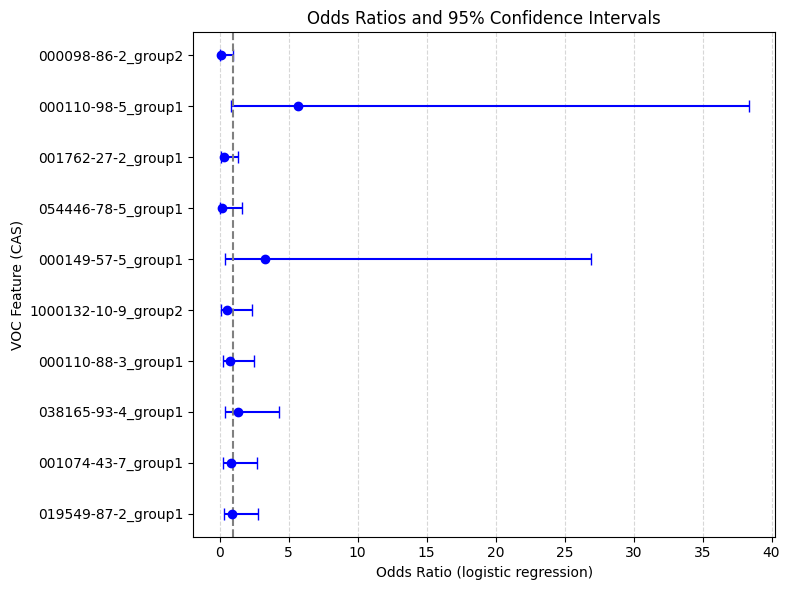

In [42]:
# Filtering and sorting
plot_df = summary_df_pretty[~summary_df_pretty["CAS"].str.contains("Intercept")].copy()  # filtering out intercept
plot_df["CAS"] = plot_df["CAS"]
plot_df = plot_df.sort_values("p", ascending=False)  # sorts similar to table above


plt.figure(figsize=(8, 6))
plt.errorbar(
    x=plot_df["OR"],
    y=plot_df["CAS"],  # CAS only
    xerr=[
        plot_df["OR"] - plot_df["95% CI Lower"],
        plot_df["95% CI Upper"] - plot_df["OR"]
    ],
    fmt='o',
    capsize=4,
    color='b'
)

plt.axvline(x=1, color='gray', linestyle='--', label='OR = 1 (no effect)')
plt.xlabel("Odds Ratio (logistic regression)")
plt.ylabel("VOC Feature (CAS)")
plt.title("Odds Ratios and 95% Confidence Intervals")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("output9_odds_ratios_plot.pdf", bbox_inches="tight")
plt.show()

In [45]:
# Passing to next notebook
import joblib

# model
joblib.dump(svm_final_demo, "svm_final_demo.pkl")

# test data
joblib.dump(x_test_demo, "x_test_demo.pkl")
joblib.dump(y_test_demo, "y_test_demo.pkl")

# feature names if needed
joblib.dump(svm_rfe_features_with_demo, "svm_rfe_features_with_demo.pkl")

['svm_rfe_features_with_demo.pkl']